In [1]:
from jax.config import config
config.update("jax_enable_x64", True)
import numpy
from galpy.potential import LogarithmicHaloPotential
from galpy.orbit import Orbit
import shsh.util, shsh.integrate
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# ``shsh``: an example shearing-sheet calculation

Set up the sheet for a logarithmic potential (that is, a flat rotation curve):

In [2]:
lp= LogarithmicHaloPotential(normalize=1.)
sheet= shsh.util.potential_to_sheet(lp,1.)

The sheet parameters are what we would expect:

In [3]:
sheet

{'R0': 1.0, 'Omega0': 1.0, 'A': 0.5}

Use the orbit of the Sun, gotten using ``galpy``

In [4]:
orb= Orbit().toPlanar()[0] #orb= Orbit([1.,0.,1.01,0.])
vxvv= shsh.util.galpy_to_sheet(orb,sheet)

and integrate the orbit using ``galpy`` and ``shsh``:

In [5]:
ts= numpy.linspace(0.,30.,1001)
orb.integrate(ts,lp)
out= shsh.integrate.integrate(vxvv,ts,sheet['Omega0'],sheet['A'])

/Users/bovy/miniconda3/envs/py37/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')



We can compare the shearing-sheet solution to the full ``galpy`` solution in shearing sheet coordinates

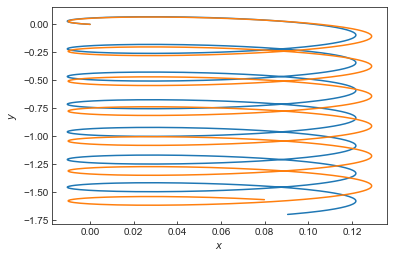

In [6]:
plot(out[0],out[1])
orb.turn_physical_off()
orb.integrate(ts,lp)
plot(*shsh.util.galpy_to_sheet(orb,sheet)[:2])
xlabel(r'$x$')
ylabel(r'$y$');

We can also convert to a ``galpy`` orbit and plot in, e.g., cylindrical coordinates:

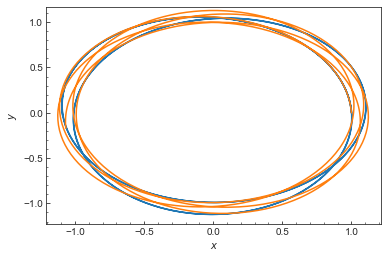

In [7]:
conv= shsh.util.sheet_to_galpy(*out,ts,sheet)
conv.plot()
orb.plot(overplot=True)

(note that these are Galactocentric $x$ and $y$, not shearing sheet). Or we can look at the energy

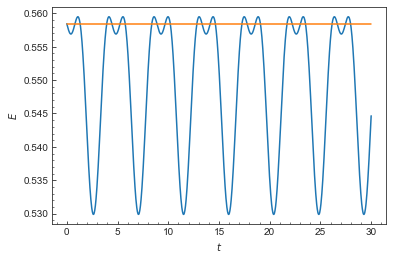

In [8]:
conv.plotE(pot=lp)
orb.plotE(overplot=True,pot=lp)

## Using JAX

``ssh.integrate`` is written using JAX, so we can 'jit' the integration function or take derivatives. For example, jitting it

In [9]:
from jax import grad, jit
jintegrate= jit(shsh.integrate.integrate)
out= jintegrate(vxvv,ts,sheet['Omega0'],sheet['A']) # force jit to happen!

We can compare:

In [10]:
%%timeit
shsh.integrate.integrate(vxvv,ts,sheet['Omega0'],sheet['A'])

945 µs ± 213 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%%timeit
jintegrate(vxvv,ts,sheet['Omega0'],sheet['A'])

684 µs ± 149 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


A little faster!

We can compute gradients as follows, for example, of the final $x$ position

In [12]:
gintegrate= grad(lambda x,*args: jintegrate(x,*args)[0][-1])

In [13]:
out= gintegrate(vxvv,ts,sheet['Omega0'],sheet['A'])
print(out)

(DeviceArray(1.98508647, dtype=float64), DeviceArray(0., dtype=float64), DeviceArray(-0.707029, dtype=float64), DeviceArray(0.98508647, dtype=float64))
